# UNIVERSIDAD ORT URUGUAY
**SANTIAGO BELZA - 286184**  
**VANESA ALLAN - 247079**

## Exploración de Métodos para Predicción de Tráfico Vehicular: Autorregresivos, Redes Recurrentes, Autoencoders y Modelos Basados en Grafos

### Contexto del Script de Análisis

El siguiente script en Python forma parte del proceso de análisis para la exploración de modelos de predicción de tráfico vehicular en el marco de la investigación realizada. Este script contiene la implementación de un modelo ARIMA.



### Importación de librerias




In [1]:
import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
!pip install pmdarima
from pmdarima.arima import auto_arima
import statsmodels.api as sm

### Lectura de los archivos de datos utilizados

In [2]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/MyDrive/MasterBigData/Datos_transito.csv" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/MyDrive/MasterBigData/data_val_transito.csv" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_train = pd.read_csv('Datos_transito.csv')
data_val = pd.read_csv('data_val_transito.csv')
print(data_train.head())

     latitud   longitud            FechaHora  velocidad_agrupada  \
0 -34.897926 -56.165434  2023-09-01 00:00:00                 0.0   
1 -34.897926 -56.165434  2023-09-01 00:15:00                 0.0   
2 -34.897926 -56.165434  2023-09-01 00:30:00                 0.0   
3 -34.897926 -56.165434  2023-09-01 00:45:00                 0.0   
4 -34.897926 -56.165434  2023-09-01 01:00:00                 0.0   

   volumen_agrupada  dsc_avenida                   key  zona  
0               0.0  18 de Julio  -34.897926-56.165434     2  
1               0.0  18 de Julio  -34.897926-56.165434     2  
2               0.0  18 de Julio  -34.897926-56.165434     2  
3               0.0  18 de Julio  -34.897926-56.165434     2  
4               0.0  18 de Julio  -34.897926-56.165434     2  


### Selección de Datos para la Avenida Bv Artigas

Se utiliza la siguiente acción para seleccionar las filas correspondientes a la avenida 'Bv Artigas' con una latitud de -34.877335 y una longitud de -56.166706 en los conjuntos de datos `data_train` y `data_val`:


In [5]:
df = data_train[(data_train['dsc_avenida'] == 'Bv Artigas')  & (data_train['latitud'] == -34.877335) & (data_train['longitud'] == -56.166706) ]
df_val = data_val[(data_val['dsc_avenida'] == 'Bv Artigas') & (data_val['latitud'] == -34.877335) & (data_val['longitud'] == -56.166706) ]

### Transformaciones necesarias en los en cada campo

Antes de utilizar los datos para entrenar modelos, es fundamental realizar ciertas transformaciones en cada campo para prepararlos adecuadamente


In [6]:
# Convertir la columna 'FechaHora' a tipo datetime
data_train['FechaHora'] = pd.to_datetime(data_train['FechaHora'])
data_val['FechaHora'] = pd.to_datetime(data_val['FechaHora'])

print(data_train.head())

     latitud   longitud           FechaHora  velocidad_agrupada  \
0 -34.897926 -56.165434 2023-09-01 00:00:00                 0.0   
1 -34.897926 -56.165434 2023-09-01 00:15:00                 0.0   
2 -34.897926 -56.165434 2023-09-01 00:30:00                 0.0   
3 -34.897926 -56.165434 2023-09-01 00:45:00                 0.0   
4 -34.897926 -56.165434 2023-09-01 01:00:00                 0.0   

   volumen_agrupada  dsc_avenida                   key  zona  
0               0.0  18 de Julio  -34.897926-56.165434     2  
1               0.0  18 de Julio  -34.897926-56.165434     2  
2               0.0  18 de Julio  -34.897926-56.165434     2  
3               0.0  18 de Julio  -34.897926-56.165434     2  
4               0.0  18 de Julio  -34.897926-56.165434     2  


### Visualización de las series a utilizar

#### Datos de entrenamiento

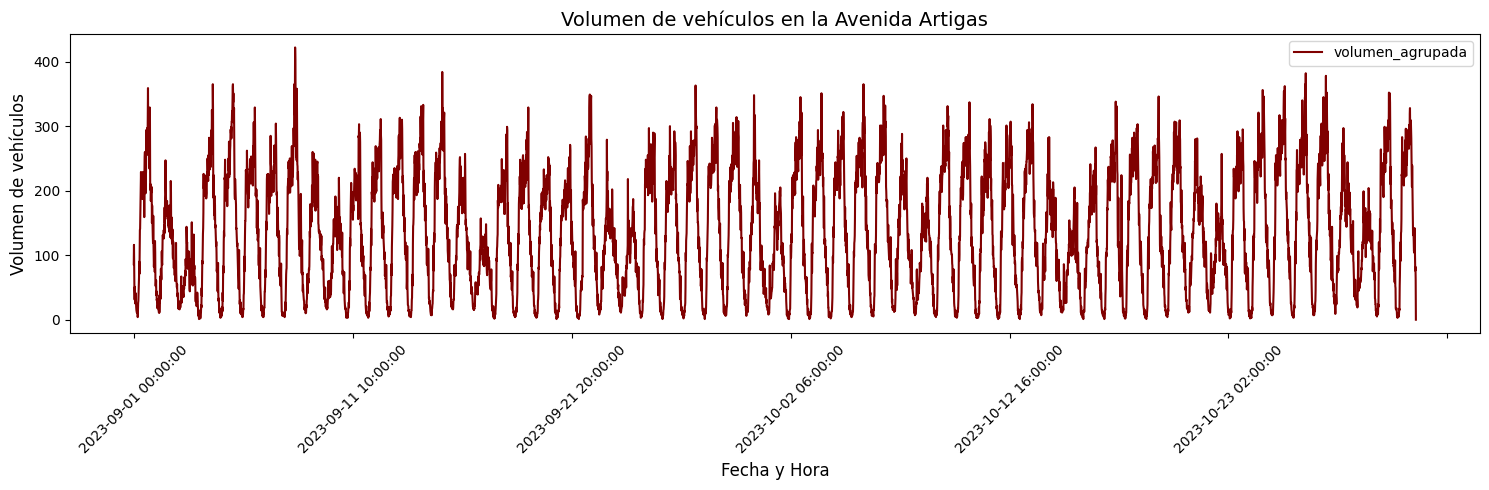

In [7]:
df.plot(x='FechaHora', y='volumen_agrupada', figsize=(15, 5), color='maroon')
plt.xlabel('Fecha y Hora', size=12)
plt.ylabel('Volumen de vehículos', size=12)
plt.title('Volumen de vehículos en la Avenida Artigas', size=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Datos de validación

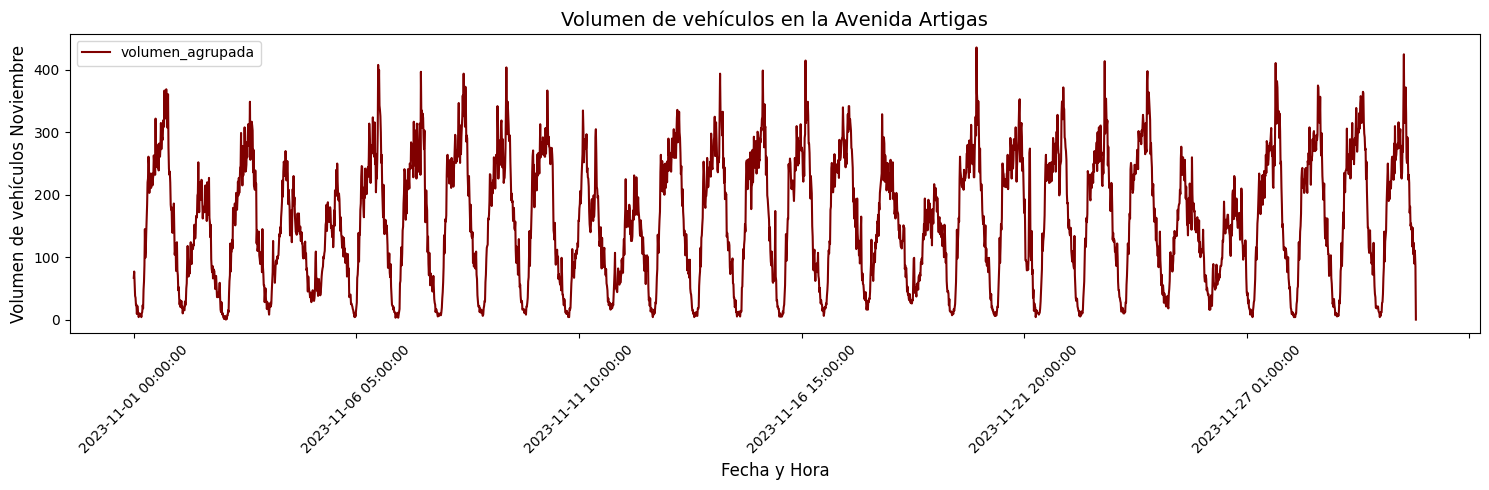

In [8]:
df_val.plot(x='FechaHora', y='volumen_agrupada', figsize=(15, 5), color='maroon')
plt.xlabel('Fecha y Hora', size=12)
plt.ylabel('Volumen de vehículos Noviembre', size=12)
plt.title('Volumen de vehículos en la Avenida Artigas', size=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Eliminación de columnas no utilizadas en el modelo actual



In [9]:
serie = df.drop(['velocidad_agrupada',	'dsc_avenida','key','zona','latitud','longitud'], axis=1)
serie_val = df_val.drop(['velocidad_agrupada',	'dsc_avenida','key','zona','latitud','longitud'], axis=1)
serie

,FechaHora,volumen_agrupada
316278,2023-09-01 00:00:00,86.0
316279,2023-09-01 00:15:00,116.0
316280,2023-09-01 00:30:00,76.0
316281,2023-09-01 00:45:00,46.0
316282,2023-09-01 01:00:00,31.0
...,...,...
322130,2023-10-31 23:00:00,93.0
322131,2023-10-31 23:15:00,76.0
322132,2023-10-31 23:30:00,82.0
322133,2023-10-31 23:45:00,63.0


### Orden e indexación de la fecha



In [10]:
serie = serie.sort_values(by='FechaHora')
serie_val = serie_val.sort_values(by='FechaHora')
serie

,FechaHora,volumen_agrupada
316278,2023-09-01 00:00:00,86.0
316279,2023-09-01 00:15:00,116.0
316280,2023-09-01 00:30:00,76.0
316281,2023-09-01 00:45:00,46.0
316282,2023-09-01 01:00:00,31.0
...,...,...
322130,2023-10-31 23:00:00,93.0
322131,2023-10-31 23:15:00,76.0
322132,2023-10-31 23:30:00,82.0
322133,2023-10-31 23:45:00,63.0


In [11]:
serie.set_index('FechaHora', inplace=True)
serie_val.set_index('FechaHora', inplace=True)
print(serie)

                     volumen_agrupada
FechaHora                            
2023-09-01 00:00:00              86.0
2023-09-01 00:15:00             116.0
2023-09-01 00:30:00              76.0
2023-09-01 00:45:00              46.0
2023-09-01 01:00:00              31.0
...                               ...
2023-10-31 23:00:00              93.0
2023-10-31 23:15:00              76.0
2023-10-31 23:30:00              82.0
2023-10-31 23:45:00              63.0
2023-11-01 00:00:00               0.0

[5857 rows x 1 columns]


In [12]:
# Convertir la columna 'Sumvolume' a una Serie
#serie_sumvolume = serie['volumen_agrupada']
#serie_val_sumvolume = serie_val['volumen_agrupada']
#serie_sumvolume

### Normalización de los dataset


In [13]:
mean = serie.mean()
std = serie.std()

serie = (serie - mean) / std

In [14]:
mean_val = serie_val.mean()
std_val = serie_val.std()

serie_val = (serie_val - mean_val) / std_val

### Gráfico de correlación

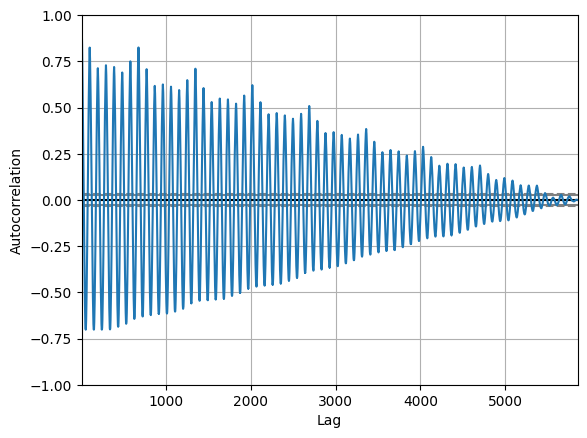

In [15]:
autocorrelation_plot(serie)
pyplot.show()

### Autoarima


In [16]:
import pmdarima as pm

modelo = auto_arima(serie, start_p=1, start_q=1, max_d=3, max_p=5, max_q=5, stationary=False, warnings=False, seasonal=True, trace=True)
modelo.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=804.719, Time=7.88 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16624.446, Time=2.80 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1065.922, Time=1.98 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11011.753, Time=3.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16622.446, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=802.499, Time=10.76 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=807.396, Time=3.01 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=801.766, Time=6.94 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=799.912, Time=9.48 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=800.647, Time=2.04 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=13.74 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=797.925, Time=0.73 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=805.408, Time=0.38 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=798.660, Time=0.95 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5857
Model:               SARIMAX(5, 0, 2)   Log Likelihood                -137.941
Date:                Thu, 21 Mar 2024   AIC                            291.883
Time:                        01:21:12   BIC                            345.286
Sample:                    09-01-2023   HQIC                           310.451
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6938      0.013     54.151      0.000       0.669       0.719
ar.L2          1.0934      0.016     69.822      0.000       1.063       1.124
ar.L3         -0.5195      0.018    -28.268      0.000      -0.556      -0.484
ar.L4         -0.1120      0.014     -7.987      0.000      -0.140      -0.085
ar.L5         -0.1666      0.011    -14.503      0.000      -0.189      -0.144
ma.L1          0.0251      0.008      3.029      0.002       0.009       0.041
ma.L2         -0.9300      0.008   -111.402      0.000      -0.946      -0.914
sigma2         0.0613      0.001     69.877      0.000       0.060       0.063
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):               723.72
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.31
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Análisis de Residuos del Modelo ARIMA


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found.

                               SARIMAX Results                                
Dep. Variable:       volumen_agrupada   No. Observations:                 5857
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -138.516
Date:                Thu, 21 Mar 2024   AIC                            295.032
Time:                        01:21:35   BIC                            355.110
Sample:                    09-01-2023   HQIC                           315.921
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.033     -0.094      0.925      -0.069       0.062
ar.L1          0.6939      0.013     53.560      0.000       0.669       0.719
ar.L2          1.0911      0.016     68.801      0.0

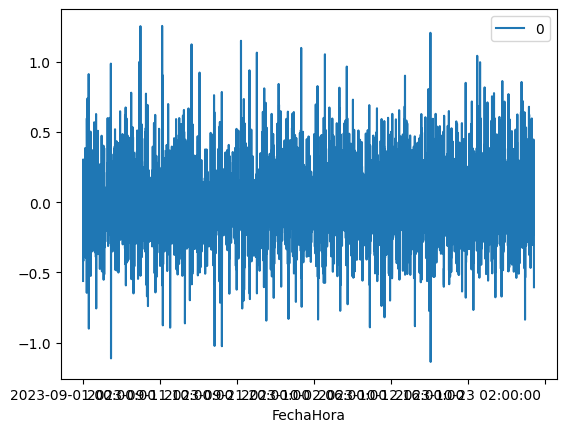

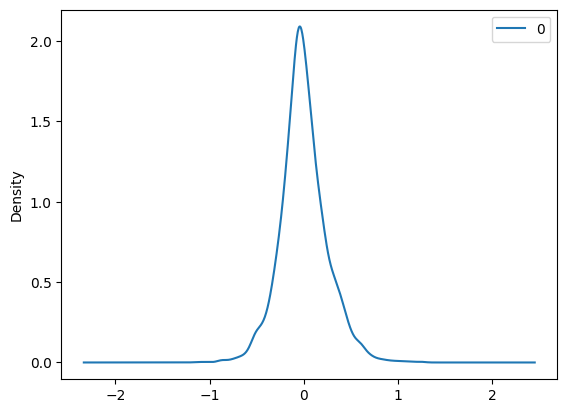

                 0
count  5857.000000
mean     -0.000037
std       0.247823
min      -1.138327
25%      -0.143235
50%      -0.018105
75%       0.132672
max       1.255800


In [17]:
modelo = ARIMA(serie, order=(5, 0, 2))
model_fit = modelo.fit()


print(model_fit.summary())


residuos = pd.DataFrame(model_fit.resid)
residuos.plot()
plt.show()

residuos.plot(kind='kde')
plt.show()

print(residuos.describe())

### Predicciones en validación


In [18]:
predicciones = model_fit.forecast(steps=len(serie_val))

predicciones


2023-11-01 00:15:00   -1.333082
2023-11-01 00:30:00   -1.391147
2023-11-01 00:45:00   -1.453246
2023-11-01 01:00:00   -1.534119
2023-11-01 01:15:00   -1.532257
                         ...   
2023-11-30 23:15:00   -0.003157
2023-11-30 23:30:00   -0.003157
2023-11-30 23:45:00   -0.003157
2023-12-01 00:00:00   -0.003157
2023-12-01 00:15:00   -0.003157
Freq: 15T, Name: predicted_mean, Length: 2881, dtype: float64

### MSE validación

In [19]:
mse = mean_squared_error(serie_val, predicciones)
print('Test MSE: %.3f' % mse)


Test MSE: 0.959


### Gráfica comparativa

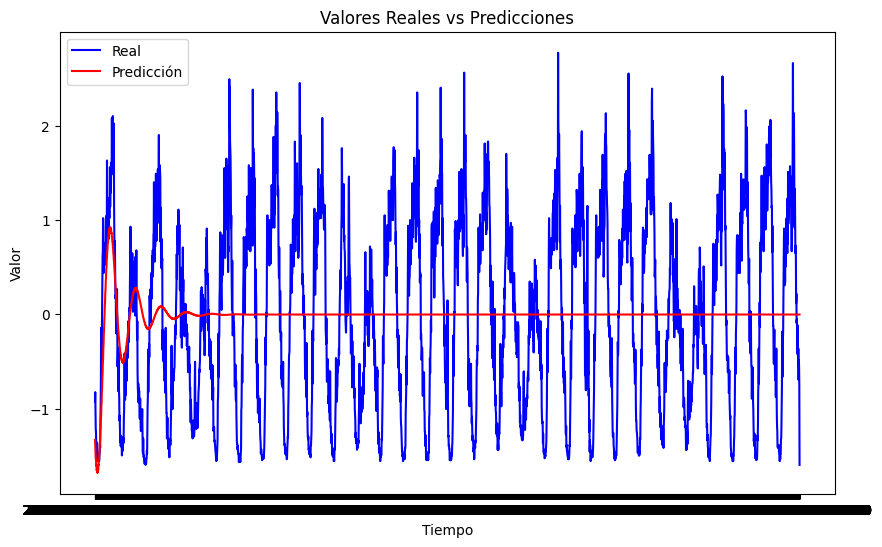

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(serie_val.index, serie_val.values, color='blue', label='Real')
ax.plot(serie_val.index, predicciones, color='red', label='Predicción')

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor')
ax.set_title('Valores Reales vs Predicciones')
ax.legend()

plt.show()